In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from  torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import util
torch.cuda.empty_cache()
X, Y = util.get_mnist()
X_torch=torch.Tensor(X)


Reading in and transforming data...


In [2]:
def torch_softplus(x):
    return torch.log1p(torch.exp(x))



In [3]:
class Variational_Autoencoder(nn.Module):
    def __init__(self,input_size,hidden_sizes,device='cpu'):
        super(Variational_Autoencoder,self).__init__()
        self.input_size=input_size
        self.hidden_sizes=hidden_sizes
        self.device=device
        self.encoder_f()
        self.decoder_f()
        #self.params=list(self.parameters())

    def encoder_f(self):
        encoder=nn.Sequential()
        inp=self.input_size
        for idx,out in enumerate(self.hidden_sizes):
            if out==self.hidden_sizes[-1]:
                encoder.add_module('L'+str(idx),nn.Linear(inp,2*out))
            else:
                encoder.add_module('L'+str(idx),nn.Linear(inp,out))
            encoder.add_module('A'+str(idx),nn.ReLU())
            inp=out
            #print(out)

        self.Encoder=encoder
        #return encoder
    def decoder_f(self):
        rev_size=self.hidden_sizes.copy()
        rev_size.reverse()
        rev_size.append(self.input_size)
        decoder=nn.Sequential()
        inp=rev_size[0]
        for idx,out in enumerate(rev_size[1:]):
            if out==rev_size[-1]:
                decoder.add_module('L'+str(idx),nn.Linear(inp,out))
                decoder.add_module('A'+str(idx),nn.Sigmoid())
            else:
                decoder.add_module('L'+str(idx),nn.Linear(inp,out))
                decoder.add_module('A'+str(idx),nn.ReLU())
            inp=out
        self.Decoder=decoder
    def forward(self,x):
        sp=nn.Softplus()
        # Encoder process
        dist=self.Encoder(x)
        # distribution splitting
        split_idx=int(self.hidden_sizes[-1])
        self.means=dist[:,:split_idx]
        #log_var=sp(dist[:,split_idx:])+1e-6
        #self.stds = torch.exp(0.5*log_var)
        self.stds=sp(dist[:,split_idx:])+1e-6
        #self.var=sp(dist[:,split_idx:])+1e-6
        # z
        z=self.means+self.stds*torch.randn_like(self.stds,device=self.device)
        #z=self.means+torch.sqrt(self.var)*torch.randn_like(self.var,device=self.device)
        x_hat=self.Decoder(z)
        return x_hat
        

    def cost_function(self,X_hat,X):
        BCE=nn.BCELoss(reduction='sum')
        #BCE=nn.MSELoss(reduction='sum')
        KLD = 0.5 * \
            torch.sum(-1 - torch.log(self.stds**2) + self.means**2 + self.stds**2)
        #KLD=(-torch.log(self.stds)+0.5*(self.stds**2+self.means**2-1)).sum()
        #KLD=(-torch.log(torch.sqrt(self.var))+0.5*(self.var+self.means**2-1)).sum()
        #print('BCE:',BCE(X_hat,X))
        #print('KLD:',KLD)
        #print('=====')
        return ((BCE(X_hat,X))+KLD),(BCE(X_hat,X)),KLD

        
    def fit(self,X,max_epoch=30,batch_sz=64):
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        BCE=[]
        KLD=[]
        costs=[]
        #optimizor=optim.Adam(self.parameters(),lr=0.001,weight_decay=0.00005)
        optimizor=optim.RMSprop(self.parameters(),lr=0.001,alpha=0.9)
        batch_num=X.shape[0]//batch_sz
        for epoch in range(max_epoch):
            X=X[torch.randperm(X.size()[0])]
            for b in range(batch_num):
                X_b=X[b*batch_sz:(b+1)*batch_sz]
                X_hat=self.forward(X_b)
                cost,bce,kld=self.cost_function(X_hat,X_b)
                optimizor.zero_grad()
                cost.backward()
                optimizor.step()
                cost/=batch_sz
                bce/=batch_sz
                kld/=batch_sz
                costs.append((cost.detach()).to('cpu'))
                BCE.append((bce.detach()).to('cpu'))
                KLD.append((kld.detach()).to('cpu'))
                #print('Loss:',cost.detach())
            #print('Epoch:',epoch+1)
            #print('Loss:',cost.detach())
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.plot([c for c in costs])
        plt.title('ELBO')
        plt.subplot(1,3,2)
        plt.plot([b for b in BCE])
        plt.title('BCE loss')
        plt.subplot(1,3,3)
        plt.plot([k for k in KLD])
        plt.title('KL divergence')
        plt.tight_layout()


    def posterior_predictive_sample(self,X):
        with torch.no_grad():
            X_p=X.reshape(28,28)
            X_hat=self.forward(X)
            X_hat_p=X_hat.reshape(28,28)
            sample=torch.bernoulli(X_hat_p)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(X_p.to('cpu'),cmap='gray')
        plt.title('Original image')
        plt.subplot(1,3,2)
        plt.imshow(X_hat_p.to('cpu'),cmap='gray')
        plt.title('Reconstruct distribution')
        plt.subplot(1,3,3)
        plt.imshow(sample.to('cpu'),cmap='gray')
        plt.title('The sample')
        plt.tight_layout()
        return (X_hat,sample)
    def prior_predictive_sample(self):
        with torch.no_grad():
            z=torch.randn([1,self.hidden_sizes[-1]],device=self.device)
            X_hat=self.Decoder(z)
            X_hat_p=X_hat.reshape(28,28)
            sample=torch.bernoulli(X_hat_p)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(X_hat_p.to('cpu'),cmap='gray')
        plt.title('The prior z')
        plt.subplot(1,2,2)
        plt.imshow(sample.to('cpu'),cmap='gray')
        plt.title('The sample')
        plt.tight_layout()
        




       


In [4]:
#device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VAE=Variational_Autoencoder(784,[200,100],device=device)
VAE=VAE.to(device)
torch.cuda.is_available()


True

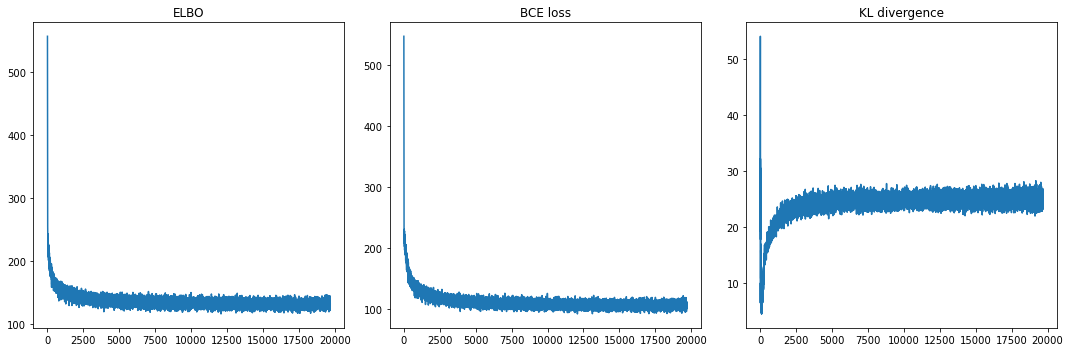

In [5]:
VAE.fit(X_torch.to(device),batch_sz=64)
#VAE.fit(X_torch,batch_sz=16)

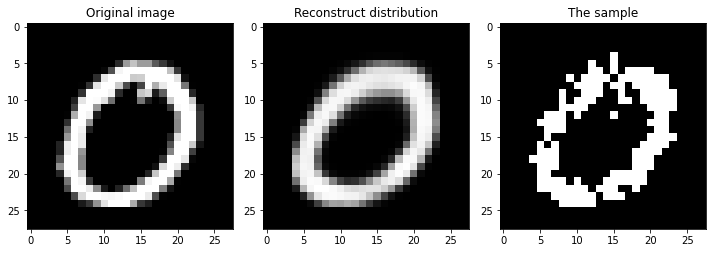

In [6]:
#VAE=VAE.to(device)
x=X_torch[200].unsqueeze(0)
a,_=VAE.posterior_predictive_sample(x.to(device))

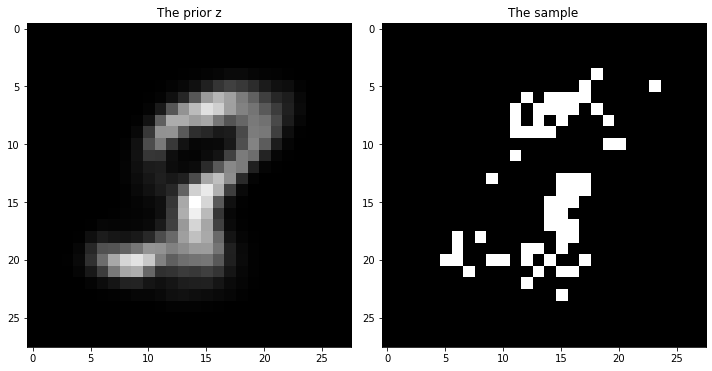

In [7]:
#VAE.forward(x.to(device))
VAE.prior_predictive_sample()


In [ ]:
n=20
x_values=np.linspace(0,5,n)
y_values=np.linspace(0,5,n)
image=np.empty((28*n,28*n))

Z=[]
for i,x in enumerate(x_values):
    for j,y in enumerate(y_values):
        z=[x,y]
        Z.append(z)

In [ ]:
Z=torch.Tensor(Z).to(device)
VAE=VAE.to(device)
VAE.device=device
#X_recon=VAE.Decoder(Z)

In [ ]:
X_recon=VAE.Decoder(Z)

In [ ]:
X_recon=X_recon.to('cpu')

In [ ]:
k=0
for i,x in enumerate(x_values):
    for j,y in enumerate(y_values):
        x_recon=X_recon[k].detach().numpy()
        k+=1
        x_recon=x_recon.reshape(28,28)
        image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=x_recon
plt.figure(figsize=(20,20))
plt.imshow(image,cmap='gray')